In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import numpy

def patch_asscalar(a):
    return a.item()

setattr(numpy, "asscalar", patch_asscalar)
from rasterstats import zonal_stats
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform

In [3]:
carro = gpd.read_file('Data/CARRO_DFCI_2X2_L93.shp')

In [4]:
dep_alpes = gpd.read_file('Data/departement_alpes.shp')

In [5]:
shp = gpd.sjoin(carro, dep_alpes, how='inner', predicate='intersects')
shp = shp[['NOM', 'geometry']]

C:\Users\SALAMA Ayoub\AppData\Local\Temp\ipykernel_9064\1422136152.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2154
Right CRS: PROJCS["RGF93_Lambert_93",GEOGCS["GCS_RGF93_geogra ...

  shp = gpd.sjoin(carro, dep_alpes, how='inner', predicate='intersects')


In [6]:
shp.columns

Index(['NOM', 'geometry'], dtype='object')

<Axes: >

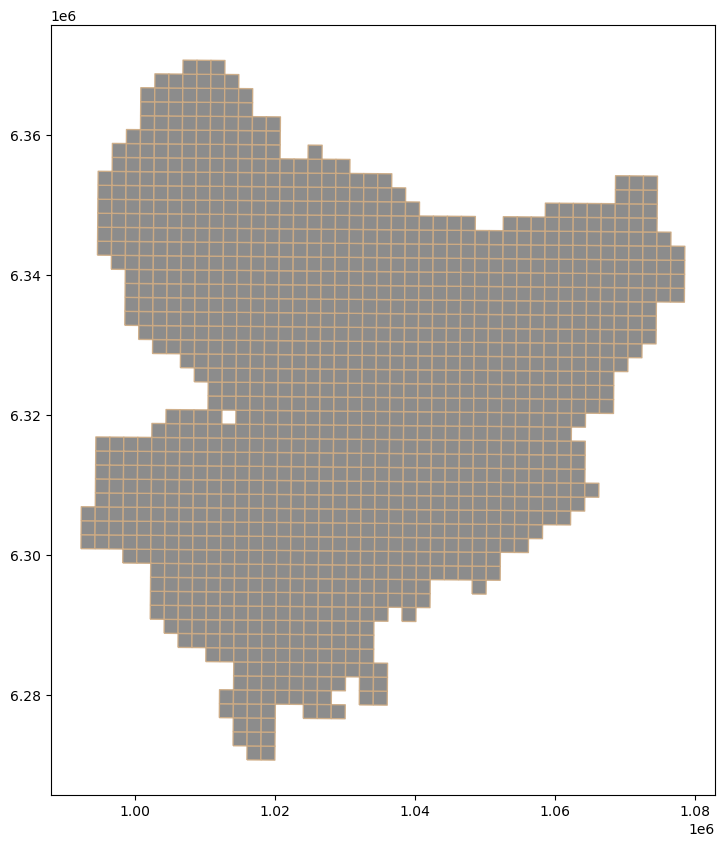

In [7]:
shp.plot(figsize=(12,10),
                color="gray",
                alpha=0.9,
                edgecolor="#CFAC84",
                linewidth=1)

In [8]:
df1 = pd.read_excel('Data/DFCI_incendie.xlsx')
df1.head()

,DFCI,Nombre d'incendies,Somme d'incendies (m2)
0,FC04K0,1,40000
1,FC06L7,1,600
2,FC20L9,1,10000
3,FC26B5,1,15000
4,FC26C2,1,25


In [9]:
shp_inc = shp.merge(df1, left_on='NOM', right_on='DFCI', how='left')
shp_inc.columns

Index(['NOM', 'geometry', 'DFCI', 'Nombre d'incendies',
       'Somme d'incendies (m2)'],
      dtype='object')

In [10]:
vege = gpd.read_file('Data/FORMATION_VEGETALE.shp')

In [11]:
joined = gpd.overlay(shp, vege, how='intersection')
joined['Area'] = joined['geometry'].area

In [12]:
joined['geometry'] = joined['geometry'].centroid

In [13]:
# Check and rename conflicting columns in shp
if 'index_left' in shp.columns or 'index_right' in shp.columns:
    shp = shp.rename(columns={'index_left': 'index_left_orig', 'index_right': 'index_right_orig'})

# Check and rename conflicting columns in joined
if 'index_left' in joined.columns or 'index_right' in joined.columns:
    joined = joined.rename(columns={'index_left': 'index_left_orig', 'index_right': 'index_right_orig'})

point_in_poly = gpd.sjoin(left_df=shp, right_df=joined, how="left", predicate="contains")
result = point_in_poly.groupby(point_in_poly.index).agg({
    'Area': 'sum'            # Sum of areas for points in each polygon
}).rename(columns={'Area': 'Surface vegetation en m2'})
shp_with_counts = shp.join(result)
shp_with_counts['Ratio']=round((shp_with_counts['Surface vegetation en m2']/4000000)*100,2)

In [14]:
shp_with_counts.columns

Index(['NOM', 'geometry', 'Surface vegetation en m2', 'Ratio'], dtype='object')

In [15]:
dfci_stats = shp_inc.merge(shp_with_counts[['NOM', 'Surface vegetation en m2', 'Ratio']], on='NOM', how='inner')

In [16]:
dfci_stats.head()

,NOM,geometry,DFCI,Nombre d'incendies,Somme d'incendies (m2),Surface vegetation en m2,Ratio
0,LD46D5,"POLYGON ((992249.212 6300903.840, 992266.476 6...",LD46D5,2.0,41000.0,3.607525e+02,0.01
1,LD46D6,"POLYGON ((992266.476 6302901.604, 992283.740 6...",LD46D6,8.0,46100.0,1.231485e+06,30.79
2,LD46D7,"POLYGON ((992283.740 6304899.371, 992301.005 6...",LD46D7,3.0,51000.0,2.061254e+06,51.53
3,LD46E5,"POLYGON ((994246.977 6300886.579, 994264.244 6...",LD46E5,2.0,1100.0,2.438110e+06,60.95
4,LD46E6,"POLYGON ((994264.244 6302884.342, 994281.512 6...",LD46E6,2.0,2100.0,3.167894e+06,79.20


In [17]:
dfci_stats['climat_majority'] = pd.DataFrame(
    zonal_stats(
        vectors=dfci_stats['geometry'], 
        raster='Data/typologie_climat_decoupe_reprojete.tif',
        stats='majority'
    )
)

c:\Anaconda\envs\myEnv\lib\site-packages\rasterstats\main.py:151: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:


In [18]:
dfci_stats['mnt_mean'] = pd.DataFrame(
    zonal_stats(
        vectors=dfci_stats['geometry'], 
        raster='Data/mnt_alpes.tif',
        stats='mean'
    )
)

c:\Anaconda\envs\myEnv\lib\site-packages\rasterstats\main.py:151: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
c:\Anaconda\envs\myEnv\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [19]:
dfci_stats['vitesseVent10m_majority'] = pd.DataFrame(
    zonal_stats(
        vectors=dfci_stats['geometry'], 
        raster='Data/vitesseVent10m.tif',
        stats='majority',
        band=4
    )
)

c:\Anaconda\envs\myEnv\lib\site-packages\rasterstats\main.py:151: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
c:\Anaconda\envs\myEnv\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [22]:
dfci_stats.head()

,NOM,geometry,DFCI,Nombre d'incendies,Somme d'incendies (m2),Surface vegetation en m2,Ratio,climat_majority,mnt_mean,vitesseVent10m_majority
0,LD46D5,"POLYGON ((992249.212 6300903.840, 992266.476 6...",LD46D5,2.0,41000.0,3.607525e+02,0.01,6.0,6.663989,0.0
1,LD46D6,"POLYGON ((992266.476 6302901.604, 992283.740 6...",LD46D6,8.0,46100.0,1.231485e+06,30.79,6.0,485.055714,0.0
2,LD46D7,"POLYGON ((992283.740 6304899.371, 992301.005 6...",LD46D7,3.0,51000.0,2.061254e+06,51.53,6.0,675.718021,3.0
3,LD46E5,"POLYGON ((994246.977 6300886.579, 994264.244 6...",LD46E5,2.0,1100.0,2.438110e+06,60.95,6.0,782.033776,0.0
4,LD46E6,"POLYGON ((994264.244 6302884.342, 994281.512 6...",LD46E6,2.0,2100.0,3.167894e+06,79.20,6.0,1135.522000,3.0


In [21]:
dfci_stats.to_file('Data/dfci_stats_python.shp')

C:\Users\SALAMA Ayoub\AppData\Local\Temp\ipykernel_9064\247706794.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dfci_stats.to_file('Data/dfci_stats_python.shp')
